In [1]:
import sys

sys.path.append('../../MembraneQuant')
from membranequant import *
import seaborn as sns
import scipy.odr as odr
from scipy.optimize import curve_fit
import sympy as sp
import scipy.stats as st

%matplotlib notebook

### Load data

In [2]:
df = pd.read_csv('res1_df.csv')
df

,Unnamed: 0,ID,Line,Condition,Path,Cyt,Mem_tot,Mem_ant,Mem_post,Dosage_af,Dosage_sub,Genotype
0,0,0,nwg201,11121830par2rnai,/Users/blandt/Desktop/Rundowns/PAR-2 RUNDOWN/E...,404.824618,277.395178,107.390318,440.576556,431.417793,266.590571,"Wild type, par-3 -/-"
1,1,1,nwg201,11121830par2rnai,/Users/blandt/Desktop/Rundowns/PAR-2 RUNDOWN/E...,1165.587924,1430.621320,1029.573618,2150.986552,1369.225169,1885.170369,"Wild type, par-3 -/-"
2,2,2,nwg201,11121830par2rnai,/Users/blandt/Desktop/Rundowns/PAR-2 RUNDOWN/E...,480.171608,193.901646,21.561371,389.190454,477.018692,617.004962,"Wild type, par-3 -/-"
3,3,3,nwg201,11121830par2rnai,/Users/blandt/Desktop/Rundowns/PAR-2 RUNDOWN/E...,507.343733,187.305648,43.381474,378.854796,472.357707,27.534898,"Wild type, par-3 -/-"
4,4,4,nwg201,11121830par2rnai,/Users/blandt/Desktop/Rundowns/PAR-2 RUNDOWN/E...,591.494680,362.198942,241.946983,503.868954,608.173290,643.590486,"Wild type, par-3 -/-"
...,...,...,...,...,...,...,...,...,...,...,...,...
111,111,111,nwg338,"tom4,15,60",/Users/blandt/Desktop/RING lines/Experiment/21...,5643.030793,3375.334091,901.075232,8431.579894,5873.060858,7140.082831,L109R
112,112,112,nwg338,"tom4,15,60",/Users/blandt/Desktop/RING lines/Experiment/21...,5718.536531,3685.000987,-1101.095871,10311.804936,6013.130394,7721.708613,L109R
113,113,113,nwg338,"tom4,15,60",/Users/blandt/Desktop/RING lines/Experiment/21...,5101.556361,3164.663614,-575.847158,9083.502720,5411.068380,6915.913835,L109R
114,114,114,nwg338,"tom4,15,60",/Users/blandt/Desktop/RING lines/Experiment/21...,5424.388696,3755.130647,-924.793446,10361.705166,5693.633993,7314.393926,L109R


In [3]:
x_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy())
y_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_tot.to_numpy())

print(x_wt_full)
print(y_wt_full)
print(y_wt_full / x_wt_full)

3923.6470294706296
9169.514604592634
2.3369876382151955


In [4]:
# x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy() / x_wt_full
# y_wt = df[df.Line == 'nwg201'].Mem_post.to_numpy() / y_wt_full

# x_pol = df[df.Line == 'nwg325'].Cyt.to_numpy() / x_wt_full
# y_pol = df[df.Line == 'nwg325'].Mem_post.to_numpy() / y_wt_full

# x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy() / x_wt_full
# y_l109r = df[df.Line == 'nwg369'].Mem_post.to_numpy() / y_wt_full

# x_ph = df[df.Line == 'od58'].Cyt.to_numpy() / x_wt_full
# y_ph = df[df.Line == 'od58'].Mem_post.to_numpy() / y_wt_full

In [5]:
x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy() / x_wt_full
y_wt = df[df.Line == 'nwg201'].Mem_tot.to_numpy() / y_wt_full

x_pol = df[df.Line == 'nwg325'].Cyt.to_numpy() / x_wt_full
y_pol = df[df.Line == 'nwg325'].Mem_post.to_numpy() / y_wt_full

x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy() / x_wt_full
y_l109r = df[df.Line == 'nwg369'].Mem_tot.to_numpy() / y_wt_full

x_ph = df[df.Line == 'od58'].Cyt.to_numpy() / x_wt_full
y_ph = df[df.Line == 'od58'].Mem_tot.to_numpy() / y_wt_full

### Conversion factors

Model uses real units, but must be converted to normalised units (cyt and mem approx on range 0-1) for optimisation as optimiser uses orthogonal distance. Hence the division above.

To convert back, multiply by appropriate factors. Actually, just need to multiply mem by y_wt_full / x_wt_full = 3.5

Also need to put cytoplasm and membrane in equivalent units. 1 membrane unit (pre) division = 3.5 cytoplasmic units (i.e. arbitraty units per um3 vs same arbitrary units per um2). This was calculated using the optogenetics method, but needs to be updated.

Then need to convert membrane units to um3. Multiply by 1 / effective_thickness_of_cortex_in_um. Thickness is approx 0.01um, but this is an estimate. Probably need to play around with this parameter.

Also need to put in absolute units. Really we have no way of knowing what these should be...


So to summarise:

Mem: * 3.5 * (y_wt_full / x_wt_full) * (1 / a) * b

Cyt: * b

In [6]:
a = 0.01
b = 1e-6

xc = b
xm = 3.5 * (y_wt_full / x_wt_full) * (1 / a) * b

### Analysis functions

In [22]:
def fitting(model, cyts, mems, verb=False):
    # Ols fit
    popt, pcov = curve_fit(model, cyts, mems)
    params_0 = popt

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: model(x, *B))
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=params_0)
        output = myodr.run()
        return output

    regression = perform_odr(cyts, mems)
    params = regression.beta
    
#     if verb:
#         print((regression.sum_square) ** 0.5)
#         print((cyts + regression.delta) ** 0.5) ## model x
#         print((regression.y) ** 0.5) ## model y
#         ## can then calculate pairwise euclidian distance between model and data
        
#         fig, ax = plt.subplots()
#         for i in range(len(cyts)):
#             xs = [cyts[i], cyts[i] + regression.delta[i]]
#             ys = [mems[i], regression.y[i]]
#             ax.scatter(xs, ys)
#             ax.set_xlim(0, 2)
#             ax.set_ylim(0, 2)
#         fig.set_size_inches(4,4)
        
    return params

def bootstrap_fitting(model, cyts, mems, n):
    params = []
    for i in range(n):  
        inds = np.random.choice(range(len(cyts)), len(cyts))
        try:
            params.append(fitting(model, cyts[inds], mems[inds]))
        except:
            pass
    
#     fig, ax = plt.subplots()
    params_array = np.array(params).T
    ax.scatter(np.log(np.array(params_array[0])), np.log(np.array(params_array[1])), s=1)
#     ax.set_xlim(0, 5)
#     ax.set_ylim(0, 3)
#     xmin, xmax = 4, 8.5
#     ymin, ymax = 6.5, 7.5
#     xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
#     positions = np.vstack([xx.ravel(), yy.ravel()])
#     values = np.vstack([np.array(params_array[0]), np.array(params_array[1])])
#     values = np.vstack([np.log(np.array(params_array[0])), np.log(np.array(params_array[1]))])
#     kernel = st.gaussian_kde(values)
#     f = np.reshape(kernel(positions).T, xx.shape)
#     cfset = ax.contourf(xx, yy, f, cmap='Blues')
#     ax.set_xlim(xmin, xmax)
#     ax.set_ylim(ymin, ymax)
#     ax.set_xlabel('d')
#     ax.set_ylabel('m')
    ax.set_xlabel('Dimerisation energy')
    ax.set_ylabel('Membrane binding energy')
    fig.set_size_inches(3, 3)
    fig.tight_layout()
        
    return params

def confidence_interval(model, cyts, mems, n_bootstrap=100, n_x=100, interval=95):
    params = bootstrap_fitting(model, cyts, mems, n=n_bootstrap)
    
    x = np.linspace(0, max(cyts), n_x)
    all_fits = np.zeros([len(x), len(params)])
    for i, _x in enumerate(x):
        for j, p in enumerate(params):
            all_fits[i, j] = model(_x, *p)
    
    all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=1)
    all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=1)
    params_lower = np.percentile(np.array(params), (100 - interval) / 2, axis=0)
    params_upper = np.percentile(np.array(params), 50 + (interval / 2), axis=0)

    return [x, all_fits_lower, all_fits_upper], [params_lower, params_upper]

def plot_analysis(x, y, model, p, ci, ax, c=None):
    ax.scatter(x, y, c=c)
#     ax.scatter(x * xc, y * xm, c=c)
    ax.plot(np.linspace(0, max(x), 100), model(np.linspace(0, max(x), 100), *p), c=c)
    ax.fill_between(*ci, color=c, alpha=0.1)
    
def full_analysis(model):
    p_wt = fitting(model, x_wt, y_wt, verb=True)
    ci_wt, prange_wt = confidence_interval(model, x_wt, y_wt)

#     p_pol = fitting(model, x_pol, y_pol, verb=True)
#     ci_pol, prange_pol = confidence_interval(model, x_pol, y_pol)

    p_l109r = fitting(model, x_l109r, y_l109r, verb=True)
    ci_l109r, prange_l109r = confidence_interval(model, x_l109r, y_l109r)

#     p_ph = fitting(model, x_ph, y_ph, verb=True)
#     ci_ph, prange_ph = confidence_interval(model, x_ph, y_ph)
    
    fig, ax = plt.subplots()
    plot_analysis(x_wt, y_wt, model, p_wt, ci_wt, ax, c='tab:blue')
#     plot_analysis(x_pol, y_pol, model, p_pol, ci_pol, ax, c='tab:orange')
    plot_analysis(x_l109r, y_l109r, model, p_l109r, ci_l109r, ax, c='tab:orange')
#     plot_analysis(x_ph, y_ph, model, p_ph, ci_ph, ax, c='tab:green')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Cytoplasmic concentration (a.u.)')
    ax.set_ylabel('Membrane concentration (a.u.)')
    fig.set_size_inches(4, 4)
    fig.tight_layout()   
    fig.savefig('Model_fitting_figs/method1.png', dpi=600, transparent=True)
    
#     fig, ax = plt.subplots()
#     yerr = np.abs(np.array([prange_wt - p_wt, prange_pol - p_pol, 
#                             prange_l109r - p_l109r, prange_ph - p_ph])[:, :, 1].T) 
#     ax.bar([1, 2, 3, 4], [p_wt[1], p_pol[1], p_l109r[1], p_ph[1]], 
#            color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], alpha=0.3, 
#            yerr=yerr, capsize=10)
#     ax.set_ylabel('Exponent')
#     ax.set_xticks([1, 2, 3, 4])
#     ax.set_xticklabels(['WT uniform', 'WT polarised', 'L109R uniform', 'PH'], rotation=45, ha='right')
#     fig.set_size_inches(4, 4)
#     fig.tight_layout()  
    
#     return fig, ax

### Solve equations - effective 2 state model

In [23]:
# c, m, ka, km = sp.symbols('c m ka km')
# f1 = 2 * (sp.log(c) - 0.5 * sp.log(1 + (2 * ka * c) + (
#     4 * ka * c + 1) ** 0.5)) - (sp.log(m) - sp.log(km) - 0.5 * sp.log(
#     1 + (2 * ka * m) + (4 * ka * m + 1) ** 0.5))
# sp.solve(f1, m)

In [24]:
# def model1(cyt, ka, km, xc=1, xm=1):
#     c = cyt * xc
#     m = 0.5 * c ** 2 * km * (c ** 2 * ka * km * (
#             2.0 * c ** 2 * ka ** 2 + 4.0 * c * ka * np.sqrt(c * ka + 0.25) + 4.0 * c * ka + 2.0 * np.sqrt(
#         c * ka + 0.25) + 1.0) - 21.1660104885167 * np.sqrt(
#         0.0178571428571429 * c ** 6 * ka ** 6 + 0.107142857142857 * c ** 5 * ka ** 5 * (
#                 c * ka + 0.25) ** 0.5 + 0.321428571428571 * c ** 5 * ka ** 5 + 0.625 * c ** 4 * ka ** 4 * (
#                 c * ka + 0.25) ** 0.5 + 0.9375 * c ** 4 * ka ** 4 + c ** 3 * ka ** 3 * (
#                 c * ka + 0.25) ** 0.5 + c ** 3 * ka ** 3 + 0.642857142857143 * c ** 2 * ka ** 2 * (
#                 c * ka + 0.25) ** 0.5 + 0.482142857142857 * c ** 2 * ka ** 2 + 0.178571428571429 * c * ka * (
#                 c * ka + 0.25) ** 0.5 + 0.107142857142857 * c * ka + 0.0178571428571429 * (
#                 c * ka + 0.25) ** 0.5 + 0.00892857142857143)) / (2.0 * c ** 4 * ka ** 4 + 8.0 * c ** 3 * ka ** 3 * (
#             c * ka + 0.25) ** 0.5 + 16.0 * c ** 3 * ka ** 3 + 20.0 * c ** 2 * ka ** 2 * (
#                                                                          c * ka + 0.25) ** 0.5 + 20.0 * c ** 2 * ka ** 2 + 12.0 * c * ka * (
#                                                                          c * ka + 0.25) ** 0.5 + 8.0 * c * ka + 2.0 * (
#                                                                          c * ka + 0.25) ** 0.5 + 1.0)
#     return x / xm

def model2(cyt, ka, km):
    c = cyt * xc
    m = 0.5 * c ** 2 * km * (c ** 2 * ka * km * (
            2.0 * c ** 2 * ka ** 2 + 4.0 * c * ka * np.sqrt(c * ka + 0.25) + 4.0 * c * ka + 2.0 * np.sqrt(
        c * ka + 0.25) + 1.0) + 21.1660104885167 * np.sqrt(
        0.0178571428571429 * c ** 6 * ka ** 6 + 0.107142857142857 * c ** 5 * ka ** 5 * (
                c * ka + 0.25) ** 0.5 + 0.321428571428571 * c ** 5 * ka ** 5 + 0.625 * c ** 4 * ka ** 4 * (
                c * ka + 0.25) ** 0.5 + 0.9375 * c ** 4 * ka ** 4 + c ** 3 * ka ** 3 * (
                c * ka + 0.25) ** 0.5 + c ** 3 * ka ** 3 + 0.642857142857143 * c ** 2 * ka ** 2 * (
                c * ka + 0.25) ** 0.5 + 0.482142857142857 * c ** 2 * ka ** 2 + 0.178571428571429 * c * ka * (
                c * ka + 0.25) ** 0.5 + 0.107142857142857 * c * ka + 0.0178571428571429 * (
                c * ka + 0.25) ** 0.5 + 0.00892857142857143)) / (2.0 * c ** 4 * ka ** 4 + 8.0 * c ** 3 * ka ** 3 * (
            c * ka + 0.25) ** 0.5 + 16.0 * c ** 3 * ka ** 3 + 20.0 * c ** 2 * ka ** 2 * (
                                                                         c * ka + 0.25) ** 0.5 + 20.0 * c ** 2 * ka ** 2 + 12.0 * c * ka * (
                                                                         c * ka + 0.25) ** 0.5 + 8.0 * c * ka + 2.0 * (
                                                                         c * ka + 0.25) ** 0.5 + 1.0)
    return m / xm


### Solve equations - effective 2 state model simplified

In [25]:
# c, m, ka, km = sp.symbols('c m ka km')

# f2 = ((m ** 2) / (c ** 2)) - (km ** 2) * ((1 + (2 * ka * m) + sp.sqrt(
#     4 * ka * m + 1)) / (1 + (2 * ka * c) + sp.sqrt(4 * ka * c + 1)))

# sp.solve(f2, m)

In [26]:
# def model3(cyt, ka, km):
#     xc = 1e-6
#     xm = 1e-4
#     c = cyt * xc
#     m = km * (c * ka * km * (2 * c * ka + np.sqrt(4 * c * ka + 1) + 1) - np.sqrt(
#         4 * c ** 3 * ka ** 3 + 6 * c ** 2 * ka ** 2 * np.sqrt(
#             4 * c * ka + 1) + 18 * c ** 2 * ka ** 2 + 8 * c * ka * np.sqrt(
#             4 * c * ka + 1) + 12 * c * ka + 2 * np.sqrt(4 * c * ka + 1) + 2)) / (
#             2 * c ** 2 * ka ** 2 + 2 * c * ka * np.sqrt(4 * c * ka + 1) + 4 * c * ka + np.sqrt(4 * c * ka + 1) + 1)
#     return m / xm


def model4(cyt, ka, km):
    c = cyt * xc
    m = c * km * (c * ka * km * (2 * c * ka + np.sqrt(4 * c * ka + 1) + 1) + np.sqrt(
        4 * c ** 3 * ka ** 3 + 6 * c ** 2 * ka ** 2 * np.sqrt(
            4 * c * ka + 1) + 18 * c ** 2 * ka ** 2 + 8 * c * ka * np.sqrt(
            4 * c * ka + 1) + 12 * c * ka + 2 * np.sqrt(4 * c * ka + 1) + 2)) / (
                2 * c ** 2 * ka ** 2 + 2 * c * ka * np.sqrt(4 * c * ka + 1) + 4 * c * ka + np.sqrt(4 * c * ka + 1) + 1)
    return m / xm


### Fit parameters to rundowns

<IPython.core.display.Javascript object>


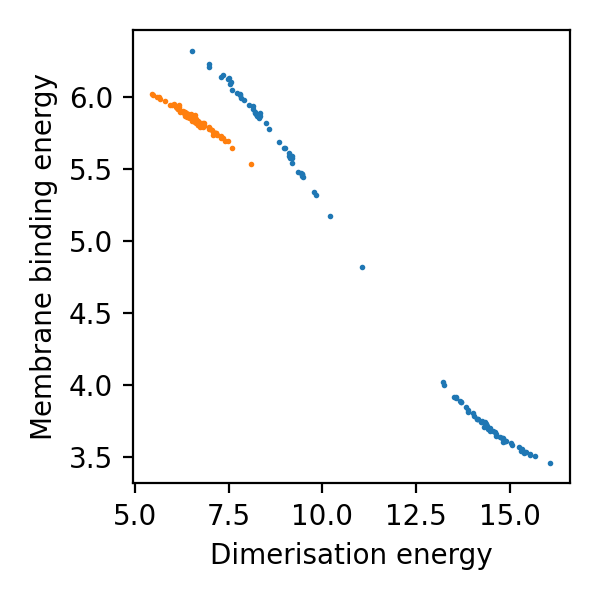

/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


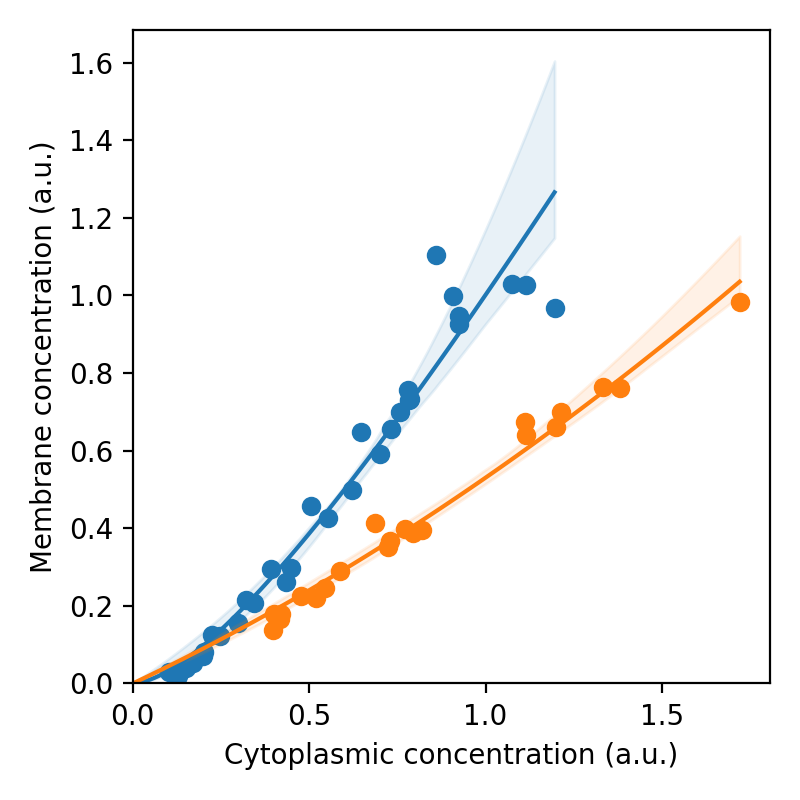

In [27]:
fig, ax = plt.subplots()
full_analysis(model4)

### Fitting with L109R dimer energy = 0

In [21]:
# model4_no_dim = lambda cyt, km: model4(cyt, 0, km)

# p_l109r = fitting(model4_no_dim, x_l109r, y_l109r)
# ci_l109r, prange_l109r = confidence_interval(model4_no_dim, x_l109r, y_l109r)

In [14]:
# print(prange_l109r)